In [1]:
# import libraries & functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

First, we import the Otto data into a Pandas DataFrame (DF). We set the column ID as the index for the DF. This will also prevent us from accidentally using it as data to test the model.

In [2]:
# import data into a dataframe ... set id column as index ... removes it from being processed in model
df = pd.read_csv('otto.csv', index_col=0)
df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61874,1,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61875,4,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61876,0,0,0,0,0,0,0,3,1,0,...,0,3,1,0,0,0,0,0,0,Class_9


In [3]:
#print number of instances
print('Number of instances: {}'.format(len(df)))

#print number of classes
print('Number of classes: {}'.format(df['target'].nunique()))

Number of instances: 61878
Number of classes: 9


## Pre-processing
Then, we need to preprocess our data to make it suitable to be used by the models.

The following steps were taken:
<li>Handle missing values in the whole dataset - we will use imputation by assigning the missing values the mode descriptive feature level across the column</li>
<li>Filter out rows that contains ALL zeros</li>
<li>Convert non-numerical class labels to numbers - to do this we assigned indices to the classes and mapped the categorical values to numbers</li>

In [4]:
# handle missing values - IMPUTATION
# assign mode of column to missing values
adjusted_df = df.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# filter out rows with all zero values
adjusted_df = adjusted_df[~(adjusted_df[adjusted_df.columns[:-1]] == 0).all(axis=1)]

# get descriptive features
descriptive = adjusted_df.drop('target', axis=1).to_numpy()
# get target features
target = adjusted_df['target']

# remove non-numerical class labels/target labels
# create a dictionary, mapping categorical class labels to integer index values
class_label_mapping = dict(enumerate(iterable=target.unique(), start=1))
# reverse keys/values in the dictionary
class_label_mapping = {value : key for (key, value) in class_label_mapping.items()}
# get numerical target values
target = target.replace(class_label_mapping).to_numpy()

In [5]:
# split data - 80% training, 20% testing
descriptive_train, descriptive_test, target_train, target_test = train_test_split(descriptive, target, test_size=0.2, random_state=42)
# display testing target data ... to briefly compare with outputs of predictions from the models
target_test

array([7, 7, 6, ..., 9, 2, 7], dtype=int64)

## Training The Models
Now that we have the data we need for our models, we need to create our models and train them. 

For kNN, we need to determine the optimal parameters that will classify our dataset the best. To do this, we will use sklearn's RandomizedSearchCV to explore the optimal value of k (limited from 1-30), optimal weighting (uniform/distance) and optimal distance metric (minkowski/euclidian/manhattan) to find the model version that has the best micro f-1 score.<br>

<i>Note: we limit the values of k for feasibility purposes - if we test too many values for our model, the test for optimal parameters would take too long to run. Time is also the reason why we are using RandomizedSearchCV instead of GridSearchCV, which may give us better model performance parameters.</i>

Once we have the optimal parameters, we will use them in our final k Nearest Neighbours model to train the dataset.

In [6]:
# k Nearest Neighbours
# determine optimal value of k ... limit range to k=1-30 to make the test for the optimal k feasible
parameters = {"n_neighbors": range(1, 30), "weights":['uniform','distance'], "metric": ['minkowski','euclidean','manhattan']}
# iterate through all parameter combinations - scoring each with the f-1 score
gridsearch = RandomizedSearchCV(KNeighborsClassifier(), parameters, scoring='f1_micro', n_iter=10, cv=5)
gridsearch.fit(descriptive_train, target_train)
# obtain the parameters that give us the best f-1 score
gridsearch.best_params_
best_weights = gridsearch.best_params_["weights"]
best_k = gridsearch.best_params_["n_neighbors"]
best_metric = gridsearch.best_params_["metric"]

print("Optimal parameters for k Nearest Neighbours:")
print(gridsearch.best_params_)

Optimal parameters for k Nearest Neighbours:
{'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}


In [7]:
# initialize knn classifier using the optimal number of neighbours and weights ... from running several times, seems like this is the optimal k value
knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, metric=best_metric)
# train the model
knn.fit(descriptive_train, target_train)
# force the model to make predictions on the testing data
knn_predicted = knn.predict(descriptive_test)

knn_predicted

array([2, 2, 6, ..., 9, 2, 7], dtype=int64)

For random forest, we need to determine the optimal number parameters that will classify our dataset the best. As what was done for kNN, we will use sklearn's RandomizedSearchCV to explore the optimal number of trees (limited from 1-30) and optimal criteria (gini index/entropy) to find the model version that has the best micro f-1 score.<br>

<i>Note: we limit the potential range of the number of trees for feasibility purposes - if we test too many values for our model, the test for optimal parameters would take too long to run. Time is also the reason why we are using RandomizedSearchCV instead of GridSearchCV, which may give us better model performance parameters.</i>

Once we have the optimal parametrs, we will use them in our final Random Forest model to train the dataset.

In [8]:
# Random Forest
# determine optimal value of k
parameters = {"criterion": ["gini", "entropy"], "n_estimators": range(1, 30)}
# iterate through all parameter combinations - scoring each with the f-1 score
gridsearch = RandomizedSearchCV(RandomForestClassifier(), parameters, scoring='f1_micro', n_iter=10, cv=5)
gridsearch.fit(descriptive_train, target_train)
# obtain the parameters that give us the best f-1 score
gridsearch.best_params_
best_criteria = gridsearch.best_params_["criterion"]
best_n = gridsearch.best_params_["n_estimators"]

print("Optimal parameters for Random Forest:")
print(gridsearch.best_params_)

Optimal parameters for random forest:
{'n_estimators': 26, 'criterion': 'gini'}


In [9]:
# initialize random forest using the optimal critera and number of trees ... from running several times, seems like these are optimal params
rf = RandomForestClassifier(criterion=best_criteria, n_estimators=best_n)
# train the model
rf.fit(descriptive_train, target_train)
# force the model to make predictions on the testing data
rf_predicted = rf.predict(descriptive_test)

rf_predicted

array([2, 7, 6, ..., 9, 2, 7], dtype=int64)

Finally, we will find the optimal parameters for Naive Bayes. We will use sklearn's RandomizedSearchCV to explore the optimal level of smoothing to find the model version that has the best micro f-1 score.

<i>Note: we limit the potential range of smoothing values for feasibility purposes - if we test too many values for our model, the test for optimal parameters would take too long to run. Time is also the reason why we are using RandomizedSearchCV instead of GridSearchCV, which may give us better model performance parameters.</i>

Once we have the optimal parametrs, we will use them in our final Naive Bayes model to train the dataset.

In [10]:
# Naive Bayes
# determine optimal value of k
parameters = {"var_smoothing": np.logspace(0,-9, num=100)}
# iterate through all parameter combinations - scoring each with the f-1 score
gridsearch = RandomizedSearchCV(GaussianNB(), parameters, scoring='f1_micro', n_iter=10, cv=5)
gridsearch.fit(descriptive_train, target_train)
# obtain the parameters that give us the best f-1 score
gridsearch.best_params_
best_smoothing = gridsearch.best_params_["var_smoothing"]

print("Optimal parameters for Naive Bayes:")
print(gridsearch.best_params_)

Optimal parameters for Naive Bayes:
{'var_smoothing': 0.0001873817422860383}


In [11]:
# Naive Bayes
# initialize naive bayes (gaussian) using the optimal smoothing value
nb = GaussianNB(priors=None, var_smoothing=best_smoothing)
# train the model
nb.fit(descriptive_train, target_train)
# force the model to make predictions on the testing data
nb_predicted = nb.predict(descriptive_test)

nb_predicted

array([4, 3, 6, ..., 9, 2, 7], dtype=int64)

## Model Results

Now, we can compare the models we just trained by using their micro (global) f-1 score. These results should be the optimal f-1 score as we chose the parameters that optimized the metric earlier.

In [12]:
# calculate f1 score ... use micro/global average (harmonic mean)
knn_f1 = f1_score(target_test, knn_predicted, average='micro') 
rf_f1 = f1_score(target_test, rf_predicted, average='micro')
nb_f1 = f1_score(target_test, nb_predicted, average='micro')

print("The f-1 scores for the 3 models are:")
print('k Nearest Neighbour f-score: {:0.4f}'.format(knn_f1))
print('Random Forest f-score: {:0.4f}'.format(rf_f1))
print('Naive Bayes f-score: {:0.4f}'.format(nb_f1))

The f-1 scores for the 3 models are:
k Nearest Neighbour f-score: 0.7955
Random Forest f-score: 0.8010
Naive Bayes f-score: 0.6242


In [15]:
print("Note that a model is considered to have performed well under the f-1 score metric when the value is closer to 1.\n")

if (knn_f1 > rf_f1 and knn_f1 > nb_f1):
    print("Comparing the results above, we can see that the k Nearest Neighbours model \
is the model that best classifies our dataset when each of the models used its optimal parameters.\n\n\
This was based on comparing the f-1 score of each model, meaning k Nearest Neighbour had the best average precision \
(of all predictions of class x, how many of them are actually x) \
and recall (how many actual class x did our model capture as x) metrics of all the models.\n\n\
PARAMETERS\nweights: {}, metric: {}, n_neighbours: {}".format(best_weights, best_metric, best_k))
elif (rf_f1 > knn_f1 and rf_f1 > nb_f1):
    print("Comparing the results above, we can see that the Random Forest model \
is the model that best classifies our dataset when each of the models used its optimal parameters.\n\n\
This was based on comparing the f-1 score of each model, meaning Random Forest had the best average precision \
(of all predictions of class x, how many of them are actually x) \
and recall (how many actual class x did our model capture as x) metrics of all the models.\n\n\
PARAMETERS\ncriterion: {}, n_estimators: {}".format(best_criteria, best_n))
elif (nb_f1 > knn_f1 and nb_f1 > rf_f1):
    print("Comparing the results above, we can see that the Naive Bayes model \
is the model that best classifies our dataset when each of the models used its optimal parameters.\n\n\
This was based on comparing the f-1 score of each model, meaning Naive Bayes had the best average precision \
(of all predictions of class x, how many of them are actually x) \
and recall (how many actual class x instances did our model capture as being x) metrics of all the models.\n\n\
PARAMETERS\nvar_smoothing: {}".format(best_smoothing))

Note that a model is considered to have performed well under the f-1 score metric when the value is closer to 1.

Comparing the results above, we can see that the Random Forest model is the model that best classifies our dataset when each of the models used its optimal parameters.

This was based on comparing the f-1 score of each model, meaning Random Forest had the best average precision (of all predictions of class x, how many of them are actually x) and recall (how many actual class x did our model capture as x) metrics of all the models.

PARAMETERS
criterion: gini, n_estimators: 26


In addition, we provide a comparison of the three models and how similarly they classified the instances in the testing dataset below. <br><br>
As we can see, k Nearest Neighbour (kNN) and Random Forest (RF) produced the most similar results between the models (around 88% similarity). We also know RF performed the best of all three models from our analysis above. Since kNN seemed to have performed very similarly to RF, it should be no surprise that it also had a good f-1 score as well (see above results).<br>

Naive Bayes (NB) had the least correlation with the two other models, with around 67% similarity. This makes sense as it also did not perform as well as the other two models, and had a significantly lower f-1 score.

<AxesSubplot:>

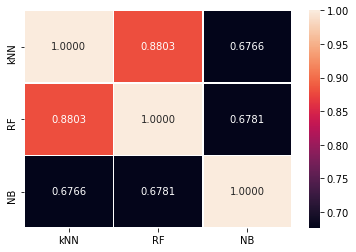

In [14]:
# prepare visual representation of pair-wise correlation between the algorithms
# create a dataframe where the columns contain the results of the three models
model_results = pd.DataFrame([knn_predicted, rf_predicted, nb_predicted]).T
model_results.columns = ['kNN', 'RF', 'NB']
# correlate the results across the columns (model algorithms)
model_correlations = model_results.corr()
# plot the results on a heatmap
f, ax = plt.subplots()
heatmap = sns.heatmap(model_correlations, annot=True, fmt="0.4f", linewidths=.5, ax=ax)

heatmap